In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+26.g2a3bfb55d.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.05 GB available memory.


In [21]:
eq = get("precise_QA")

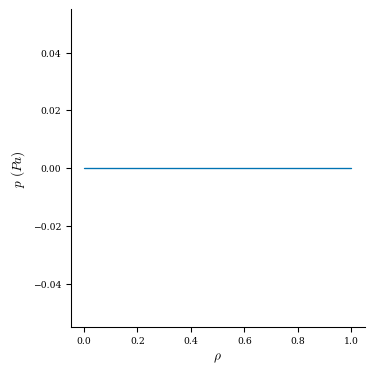

In [22]:
plot_1d(eq, "pressure");

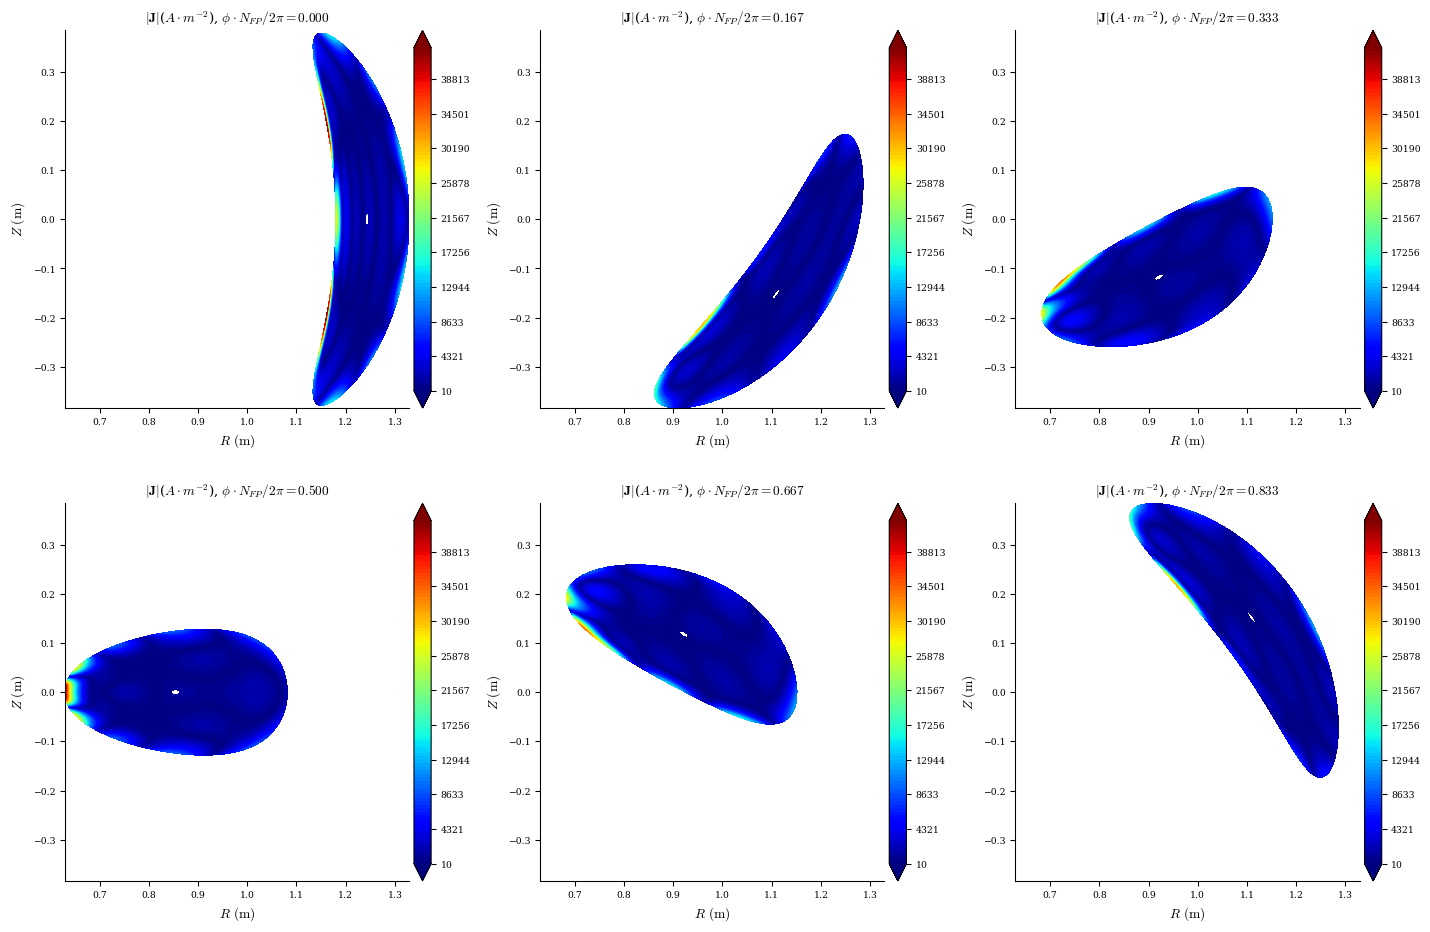

In [23]:
plot_section(eq, "|J|");

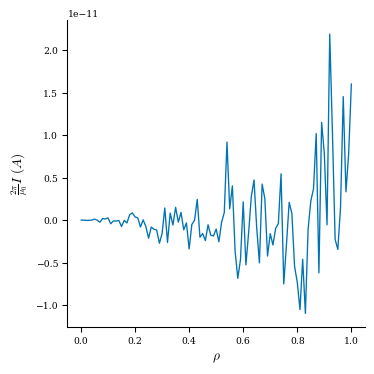

In [24]:
plot_1d(eq, "current");